In [1]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('./src/')

In [2]:
from typing import Literal, List, Tuple, Optional, Any, Dict

import ot
import torch
from torch.nn import functional as F
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from csbm.data import Prior

## Helpers

In [26]:
def plot_coupling(
    coupling: torch.Tensor,
    figure_kwargs: Optional[Dict[str, Any]] = None,
    heatmap_kwargs: Optional[Dict[str, Any]] = None,
):
    if figure_kwargs is None:
        figure_kwargs = {'figsize': (10, 8)}
    plt.figure(**figure_kwargs)

    if heatmap_kwargs is None:
        heatmap_kwargs = {'cmap': 'viridis', 'annot': False, 'fmt': '0.2f'}
    sns.heatmap(coupling.numpy(), **heatmap_kwargs)
    plt.title('Estimated Coupling Matrix Heatmap')
    plt.xlabel('Categories')
    plt.ylabel('Categories') 
    plt.show()

def plot_convergence(
    experiments: pd.DataFrame, 
    label: str, 
    title: str,
    figure_kwargs: Optional[Dict[str, Any]] = None,
):
    threshold = 1e-10
    if figure_kwargs is None:
        figure_kwargs = {'figsize': (10, 8)}
    plt.figure(**figure_kwargs)
    
    ax = sns.lineplot(
        data=experiments,
        x='iteration',
        y='kl_divergence',
        hue=label,
    )
    ax.axhline(threshold, color='black', linewidth=2, label=f'threshold = {threshold:.0e}')
    x0, x1 = ax.get_xlim()
    y1 = ax.get_ylim()[1]
    clip_box = patches.Rectangle(
        (x0, threshold),
        x1 - x0,
        y1 - threshold,
        transform=ax.transData
    )
    for line in ax.lines:
        line.set_clip_path(clip_box)

    ax.set_title(title, fontsize=18)
    ax.set_xlabel(r'D-IMF iterations ($l$)', fontsize=14)
    ax.set_ylabel(r'$KL(q^l(x_0, x_1) || q^*(x_0,x_1))$', fontsize=14)
    ax.set_yscale('log')
    ax.set_ylim(5e-11, 1e0)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

## D-IMF

The reciprocal projection $proj_{\mathcal R}$ is straightforward.
Constructing the **Markovian** projection, on the other hand, is more delicate.
Its defining property is that it preserves the one-step transition kernels of the reference process $q^{\text{ref}}$.  Hence we copy either the

$$
\Bigl\{[proj_{\mathcal R}(q)]\bigl(x_{t_n}\mid x_{t_{n-1}}\bigr)\Bigr\}_{n=2}^{N}
\qquad\text{(forward parameterisation)}
$$

or the

$$
\Bigl\{[proj_{\mathcal R}(q)]\bigl(x_{t_{n-1}}\mid x_{t_n}\bigr)\Bigr\}_{n=2}^{N}
\qquad\text{(backward parameterisation)}
$$

directly from $q^{\text{ref}}$.

For each D-IMF iteration $l$ these kernels can be extracted from the joint distribution

$$
q(x_{t_n},x_{t_{n-1}})
      = \sum_{x_0,x_1\in\mathcal X}
        \underbrace{q^{l}(x_0,x_1)}_{\text{coupling}}
        \underbrace{q^{\text{ref}}\bigl(x_{t_n}\mid x_0,x_1\bigr)}_{\text{bridge}}
        \underbrace{q^{\text{ref}}\bigl(x_{t_{n-1}}\mid x_{t_n},x_1\bigr)}_{\text{posterior}}.
$$

Finally, marginalising this joint law over $x_0$ (to obtain the forward kernel) or $x_1$ (for the backward kernel) and then applying the definition of conditional probability yields the required forward or backward transition distributions.

The updated coupling $q^{\,l+1}(x_0,x_1)$ is obtained by taking the product of all conditional factors and weighting the result with the appropriate marginal, $p_0(x_0)$ or $p_1(x_1)$.

In [ ]:
def get_transition_matrix(
    fb: Literal['forward', 'backward'], 
    coupling: torch.Tensor,
    prior: Prior, 
    t: int
) -> torch.Tensor:
    num_categories = prior.num_categories

    # Calculate posterior probs
    x_0 = torch.arange(num_categories)
    x_tn = torch.arange(num_categories)
    x_0, x_tn =  torch.meshgrid(x_0, x_tn)
    x_0, x_tn = x_0.flatten(), x_tn.flatten()
    t_n = torch.full(size=(x_tn.shape[0],), fill_value=t)
    log_posterior = prior.posterior_logits(x_start=x_0, x_t=x_tn, t=t_n)
    log_posterior = log_posterior.reshape(3 * [num_categories])[:, None, :, :] # 0, 1, t_n, t_nm1

    # Calculate bridge probs
    x_0 = torch.arange(num_categories)
    x_1 = torch.arange(num_categories)
    x_0, x_1 =  torch.meshgrid(x_0, x_1)
    x_0, x_1 = x_0.flatten(), x_1.flatten()
    log_bridge = prior.bridge_logits(x_start=x_0, x_end=x_1, t=t_n)
    log_bridge = log_bridge.reshape(3 * [num_categories])[:, :, :, None] # 0, 1, t_n, t_nm1

    probs = (log_posterior + log_bridge).exp() * coupling[:, :, None, None]
    joint_distribution = probs.sum(dim=[0, 1])
    if fb == 'forward':
        return (joint_distribution / joint_distribution.sum(dim=0, keepdim=True)).T
    else:
        return (joint_distribution / joint_distribution.sum(dim=1, keepdim=True))

In [36]:
def categorical_d_imf(
    num_imf_iterations: int, 
    p_0: torch.Tensor, 
    p_1: torch.Tensor,
    true_coupling: torch.Tensor,
    prior: Prior,
) -> Tuple[torch.Tensor, pd.DataFrame]:
    num_categories = prior.num_categories
    num_timesteps = prior.num_timesteps
    
    coupling = p_0[:, None] * p_1[None, :]
    kl = F.kl_div(torch.log(coupling + prior.eps), torch.log(true_coupling + prior.eps), log_target=True, reduction='batchmean')
    kl_divs = [kl.item()]

    for iteration in range(1, num_imf_iterations + 1):
        transition_probabilities = torch.eye(num_categories, dtype=torch.float64)
        for t_n in range(1, num_timesteps + 2):
            transition_probabilities @= get_transition_matrix('forward', coupling, prior, t_n)
        coupling = p_0[:, None] * transition_probabilities
        assert torch.isclose(coupling.sum(), torch.ones(1, dtype=torch.float64)).all(), \
            f'Forward {iteration}: Coupling marginal is not equal to 1'
        
        transition_probabilities = torch.eye(num_categories, dtype=torch.float64)
        for t_n in reversed(range(1, num_timesteps + 2)):
            transition_probabilities @= get_transition_matrix('backward', coupling, prior, t_n)
        coupling = transition_probabilities.T * p_1[None, :]
        assert torch.isclose(coupling.sum(), torch.ones(1, dtype=torch.float64)).all(), \
            f'Backward {iteration}: Coupling marginal is not equal to 1'
        
        kl = F.kl_div(torch.log(coupling + prior.eps), torch.log(true_coupling + prior.eps), log_target=True, reduction='batchmean')
        kl_divs.append(kl.item())

    if prior.prior_type == 'gaussian':
        prefix = r'$q^{\text{gauss}}$'
    elif prior.prior_type == 'uniform':
        prefix = r'$q^{\text{unif}}$'
    experiment = pd.DataFrame({
        'iteration': range(num_imf_iterations + 1),
        'kl_divergence': kl_divs,
        'alpha': [fr'{prefix}: $\alpha={prior.alpha}$'] * (num_imf_iterations + 1),
        'num_timesteps': [fr'{prefix}: $N={num_timesteps}$'] * (num_imf_iterations + 1)
    })
    return coupling, experiment

# Test

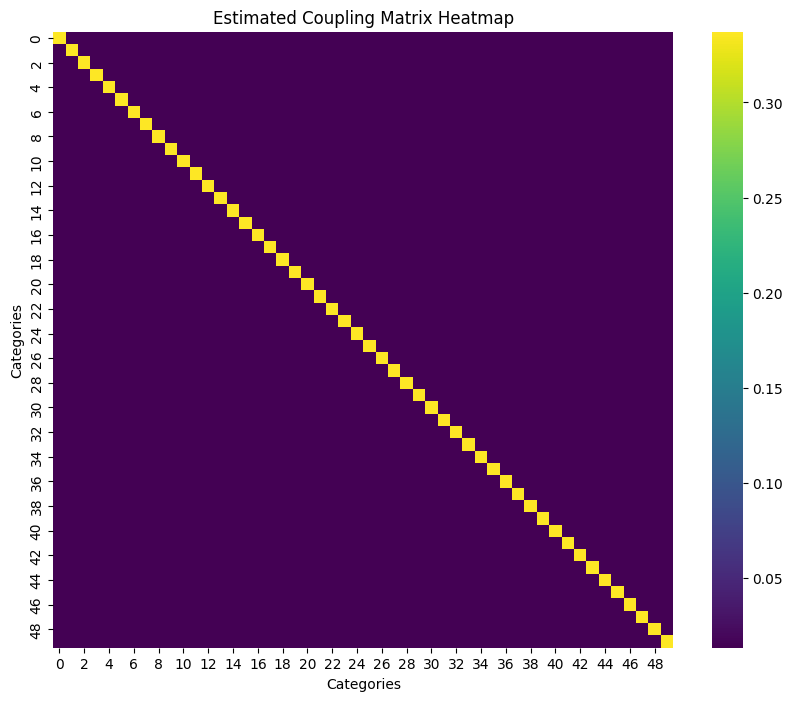

In [42]:
alpha = 0.01
dim = 1
num_categories = 50
num_timesteps = 10
num_skip_steps = 10
prior_type = 'uniform'

p_0 = torch.full((num_categories**dim,), 1 / num_categories**dim, dtype=torch.float64)
p_1 = torch.arange(1, num_categories**dim+1, dtype=torch.float64) / torch.sum(torch.arange(1, num_categories**dim+1, dtype=torch.float64))
prior = Prior(
    alpha=alpha,
    num_categories=num_categories ** dim,
    num_timesteps=num_timesteps,
    num_skip_steps=num_skip_steps,
    prior_type=prior_type,
    dtype=torch.float64,
)
plot_coupling(prior.p_cum[-1])

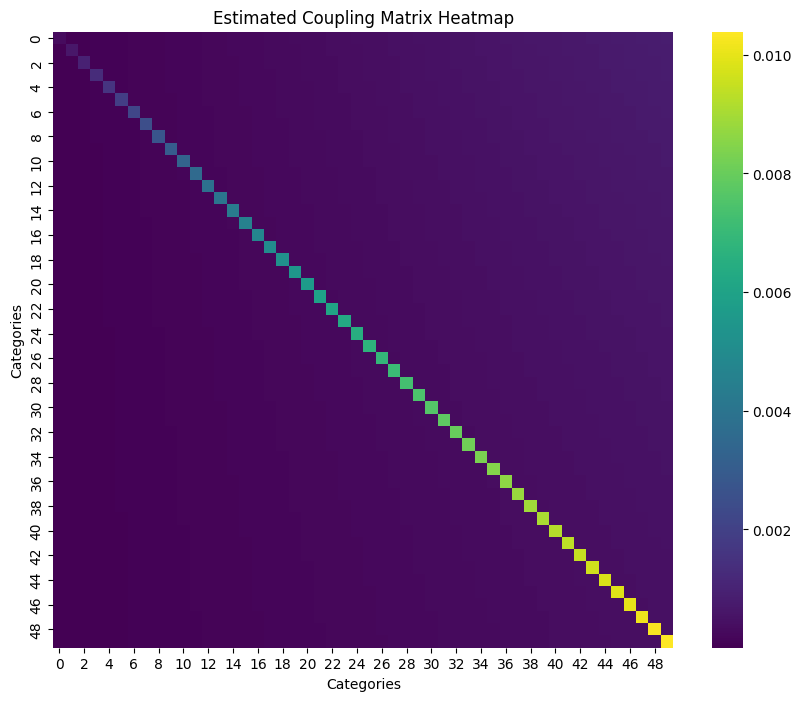

In [43]:
true_coupling: torch.Tensor = ot.sinkhorn(p_0, p_1, -torch.log(prior.p_cum[-1]), reg=1) # type: ignore
plot_coupling(true_coupling)

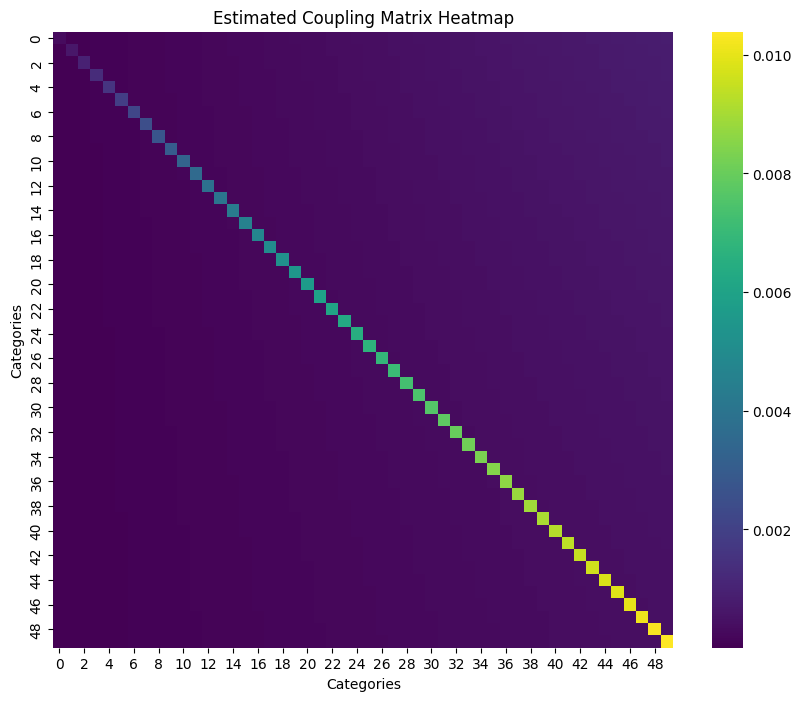

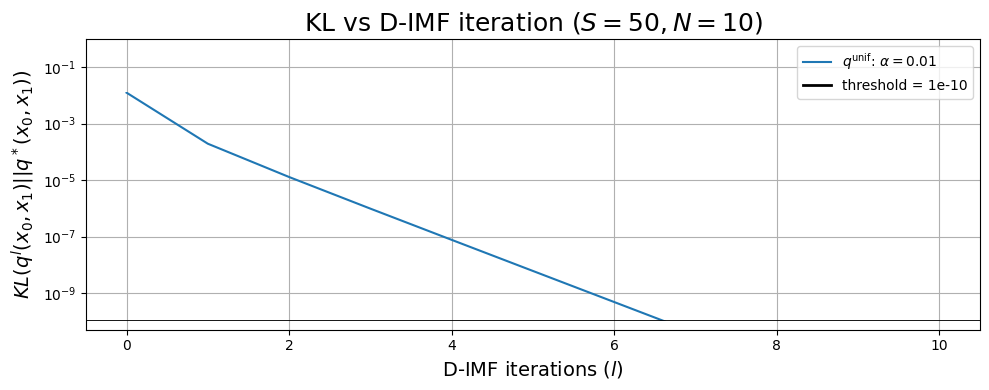

In [44]:
num_imf_iterations = 10
coupling, experiment = categorical_d_imf(num_imf_iterations, p_0, p_1, true_coupling, prior)

plot_coupling(coupling)
plot_convergence(
    experiment, 
    'alpha', 
    title=fr'KL vs D-IMF iteration ($S={num_categories}, N = {num_timesteps}$)', 
    figure_kwargs={'figsize': (10, 4), 'dpi': 100}
)

# Multiple experiments

In [60]:
dim = 1
num_categories = 50
num_imf_iterations = 10

p_0 = torch.full((num_categories**dim,), 1 / num_categories**dim, dtype=torch.float64)
p_1 = torch.arange(1, num_categories**dim+1, dtype=torch.float64) / torch.sum(torch.arange(1, num_categories**dim+1, dtype=torch.float64))

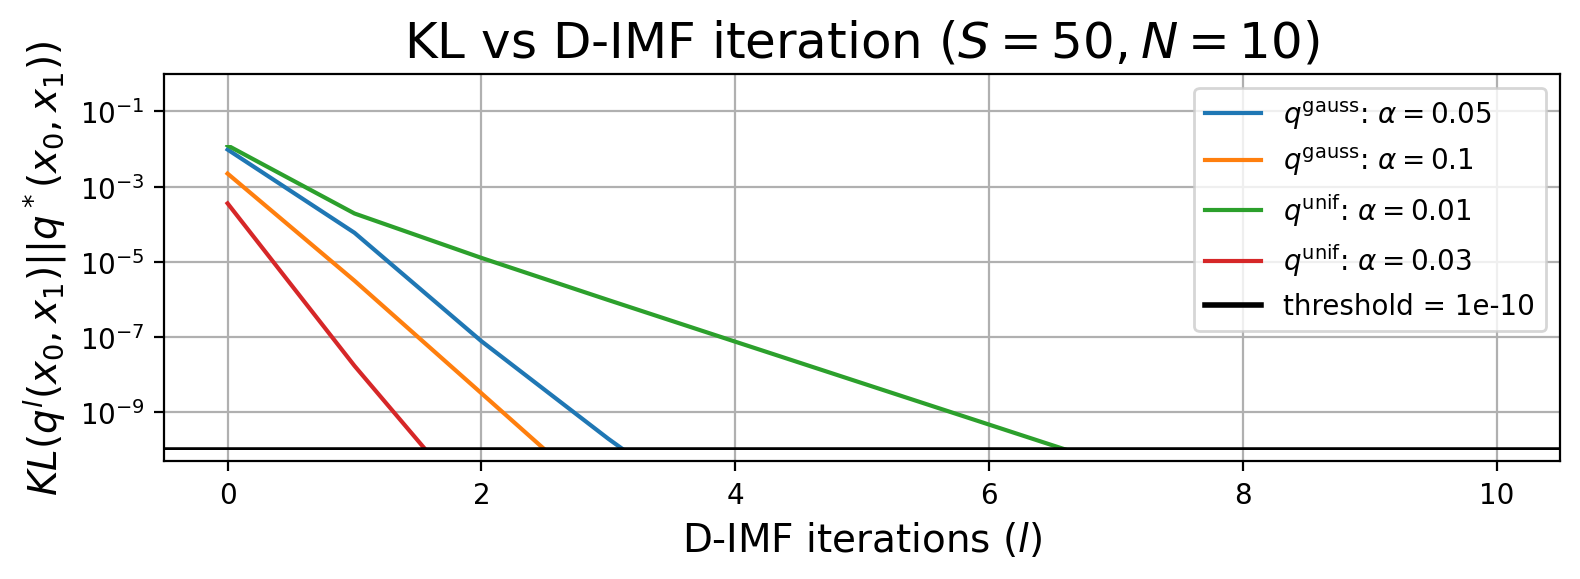

In [61]:
num_timesteps = 10
num_skip_steps = 10

experiments = []
for alpha, prior_type in [(0.05, 'gaussian'), (0.1, 'gaussian'), (0.01, 'uniform'), (0.03, 'uniform')]:
    prior = Prior(
        alpha=alpha,
        num_categories=num_categories ** dim,
        num_timesteps=num_timesteps,
        num_skip_steps=num_skip_steps,
        prior_type=prior_type, # type: ignore
        dtype=torch.float64,
    )
    true_coupling: torch.Tensor = ot.sinkhorn(p_0, p_1, -torch.log(prior.p_cum[-1]), reg=1) # type: ignore

    _, experiment = categorical_d_imf(num_imf_iterations, p_0, p_1, true_coupling, prior)
    experiments.append(experiment)
figure_kwargs = {'figsize': (8, 3), 'dpi': 200}
plot_convergence(
    pd.concat(experiments), 'alpha', 
    title=fr'KL vs D-IMF iteration ($S={num_categories}, N = {num_timesteps}$)', 
    figure_kwargs=figure_kwargs
)

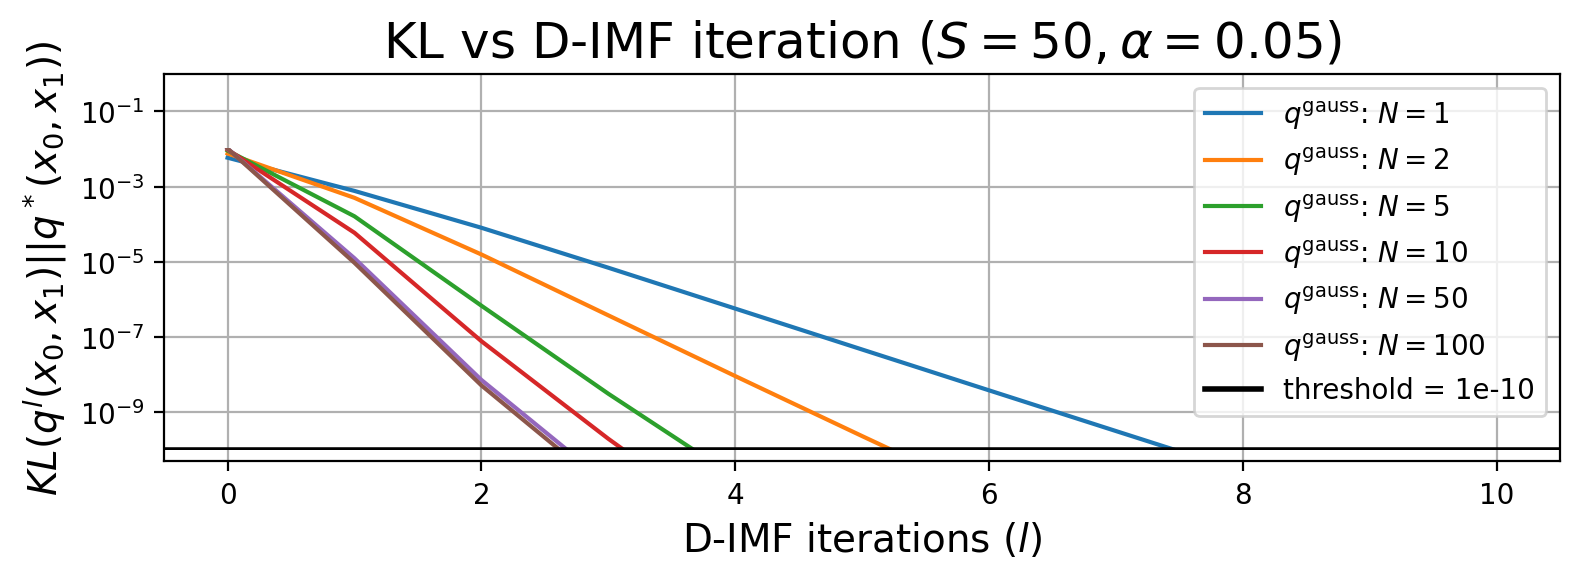

In [62]:
alpha = 0.05
prior_type = 'gaussian'

experiments = []
for num_timesteps in [1, 2, 5, 10, 50, 100]:
    num_skip_steps = 100 // num_timesteps # we want to have the sampe reference process
    prior = Prior(
        alpha=alpha,
        num_categories=num_categories ** dim,
        num_timesteps=num_timesteps,
        num_skip_steps=num_skip_steps,
        prior_type=prior_type,
        dtype=torch.float64,
    )
    true_coupling: torch.Tensor = ot.sinkhorn(p_0, p_1, -torch.log(prior.p_cum[-1]), reg=1) # type: ignore

    _, experiment = categorical_d_imf(num_imf_iterations, p_0, p_1, true_coupling, prior)
    experiments.append(experiment)
figure_kwargs = {'figsize': (8, 3), 'dpi': 200}
plot_convergence(
    pd.concat(experiments), 'num_timesteps', 
    title=fr'KL vs D-IMF iteration ($S={num_categories}, \alpha = {alpha}$)', 
    figure_kwargs=figure_kwargs
)

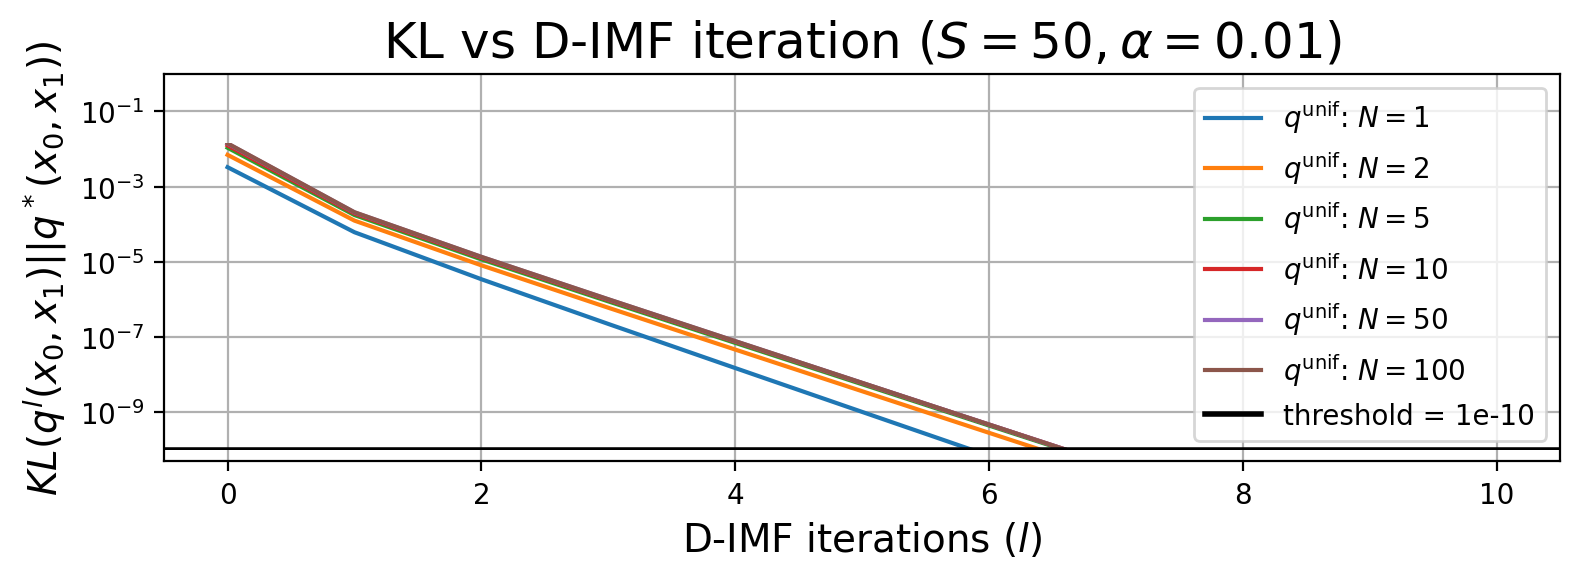

In [63]:
alpha = 0.01
prior_type = 'uniform'

experiments = []
for num_timesteps in [1, 2, 5, 10, 50, 100]:
    num_skip_steps = 100 // num_timesteps # we want to have the sampe reference process
    prior = Prior(
        alpha=alpha,
        num_categories=num_categories ** dim,
        num_timesteps=num_timesteps,
        num_skip_steps=num_skip_steps,
        prior_type=prior_type,
        dtype=torch.float64,
    )
    true_coupling: torch.Tensor = ot.sinkhorn(p_0, p_1, -torch.log(prior.p_cum[-1]), reg=1) # type: ignore

    _, experiment = categorical_d_imf(num_imf_iterations, p_0, p_1, true_coupling, prior)
    experiments.append(experiment)
figure_kwargs = {'figsize': (8, 3), 'dpi': 200}
plot_convergence(
    pd.concat(experiments), 'num_timesteps', 
    title=fr'KL vs D-IMF iteration ($S={num_categories}, \alpha = {alpha}$)', 
    figure_kwargs=figure_kwargs
)